# Zero-shot image retrieval using CLIP

## Packages import

In [1]:
# Preparation for Colab
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
from pkg_resources import packaging
import torch

# Check pytorch version
print("Torch version:", torch.__version__)

import clip

# Check available CLIP image encoder and text encoder models
clip.available_models()

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nmed5v3d
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nmed5v3d
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Torch version: 2.0.1+cu117


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [2]:
# load model
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 28.8MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
import os
# import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from torchvision.datasets import CIFAR100
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:05<00:00, 28235471.29it/s]


Extracting /home/wensonghu/.cache/cifar-100-python.tar.gz to /home/wensonghu/.cache


## Text setup and encode

In [5]:
# Set texts
# There are 100 labels in cifar100
# text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
# text_descriptions = ["Black and white squares",
#                      "A picture of galaxy",
#                      "Several coins",
#                      "Color wheel",
#                      ]
text_descriptions = ["An elephant",
                     "A crocodile",
                     "Sky",
                     "A cat",
                     "Sunset",
                     "Two trees"]
# print(len(text_descriptions))

# Preprocess texts
text_tokens = clip.tokenize(text_descriptions).cuda()
# print(text_tokens.size()) # size(100, 77)

# Encode texts
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

## Image setup and encode

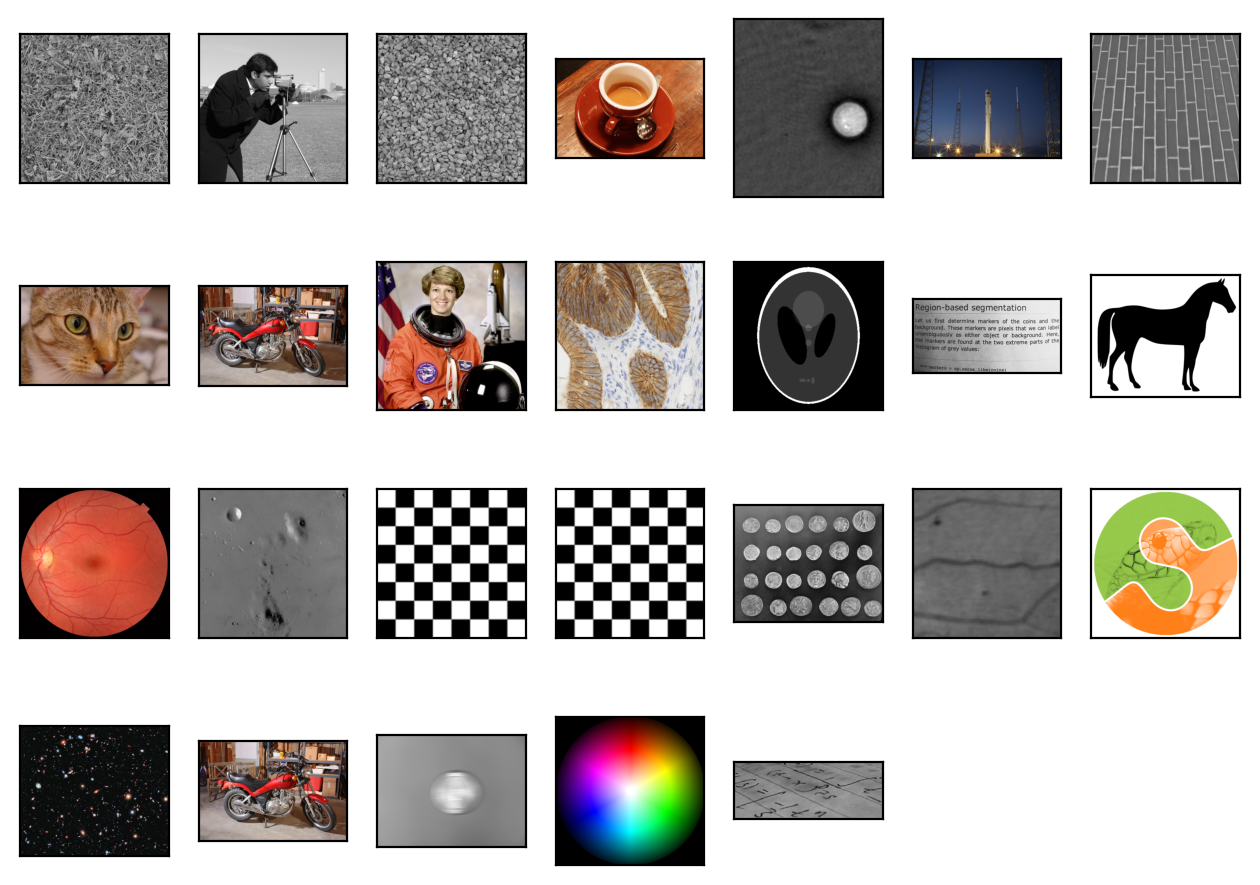

In [5]:
# Get images in skimage

# images = [preprocess(image) for image in cifar100.data]#[:100]
# print(type(images[0]))
# print(len(images))
# print(images[0].shape)
# plt.imshow(images[0])

original_images = []
images = []
# Get image file name (image.jpg or image.png) as variable: "filename"
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    # Truncat the filaname (image.jpg) to just name (image)
    name = os.path.splitext(filename)[0]

    # Want the selected image as described in "discriptions"
    # if name not in descriptions:
    #     continue

    # Get the image and store it in variable "image"
    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    # Display image with caption
    plt.subplot(4, 7, len(images) + 1)
    plt.imshow(image)
    # plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    # Set "images" and "texts"
    # print(type(image))
    original_images.append(image)
    images.append(preprocess(image)) # image preprocess
    # texts.append(descriptions[name])

plt.tight_layout()

# Preprocess images
image_input = torch.tensor(np.stack(images)).cuda()

# Encode images
with torch.no_grad() :
  image_features = model.encode_image(image_input).float()



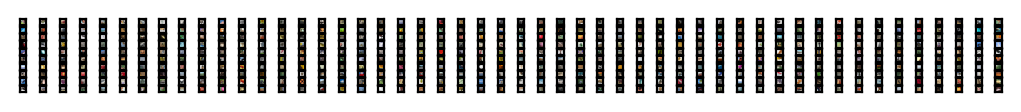

In [6]:
# Get images in cifar100
from matplotlib import cm

# print(type(cifar100.data))
# print(cifar100.data.shape)

# plt.imshow(cifar100.data[100])
# print(type(cifar100.data[100]))
# print(cifar100.data[100].shape)

original_images = []
images = []

for i, image in enumerate(cifar100.data[:500]) :
  # print(image.shape)

  plt.subplot(100, 50, i + 1)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  image = Image.fromarray(np.uint8(image)).convert('RGB')

  original_images.append(image)
  images.append(preprocess(image))

# Preprocess images
image_input = torch.tensor(np.stack(images)).cuda()

# Encode images
with torch.no_grad() :
  image_features = model.encode_image(image_input).float()

## Get cosine similarity and predict

In [7]:
# Calculate cosine similarity and probability
text_probs = (100.0 * image_features @ text_features.T).T.softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
# print(text_probs)
# print(top_labels)
# print(top_probs)

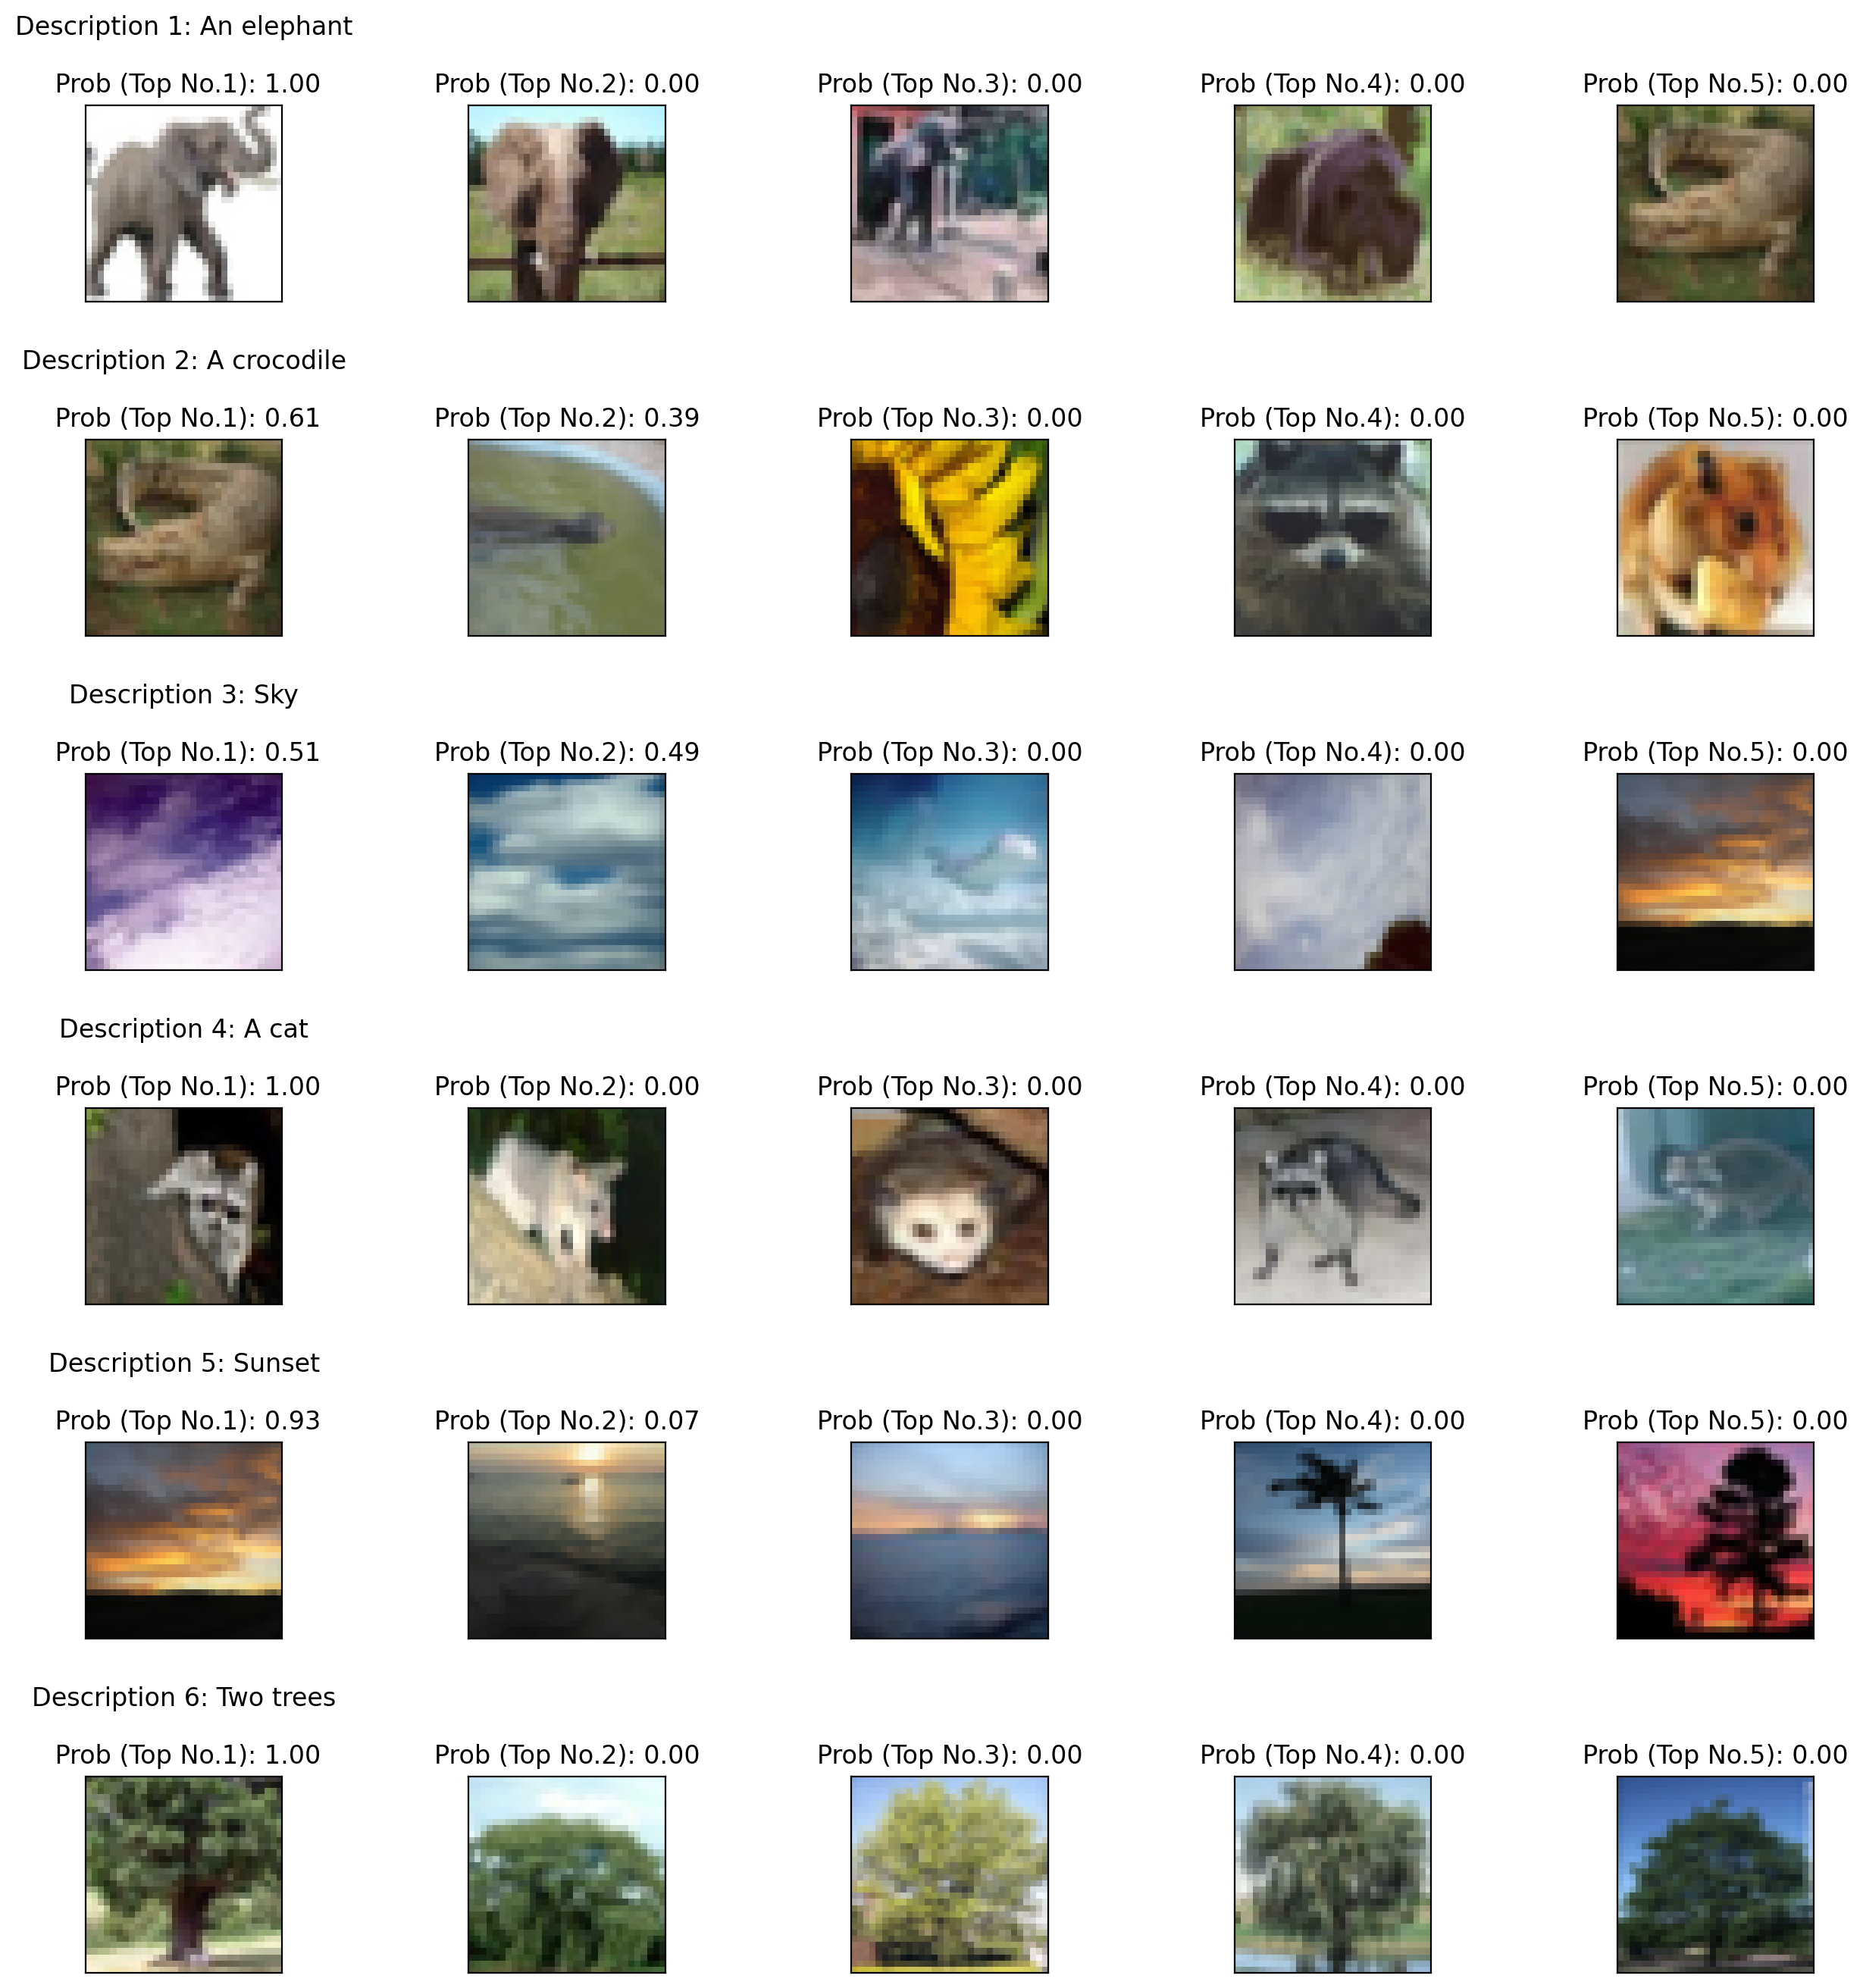

In [14]:
# Visualize, get most possible top 5 images for text description
plt.figure(figsize=(16, 16))

# Top 1 image display
# for i, text in enumerate(text_descriptions) :
#     plt.subplot(1, 3, i + 1)

#     plt.imshow(original_images[top_labels[i]])
#     plt.title(f"{text}\n Probability: {top_probs[i].item()}")
#     plt.xticks([])
#     plt.yticks([])


# Top 5 image display
topk = 5
count = 0
for j, text in enumerate(text_descriptions) :
  for i in range(topk) :
      plt.subplot(len(text_descriptions), topk, [index + 1 for index in range(5 * len(text_descriptions))][count] )

      if count % 5 == 0 :
        plt.imshow(original_images[top_labels[j][i]])
        plt.title(f"Description {j + 1}: {text}\n \n Prob (Top No.1): {top_probs[j][i].item():.2f}")

      else :
        plt.imshow(original_images[top_labels[j][i]])
        # plt.title(f"Probability: {top_probs[j][i].item()}")
        plt.title(f"Prob (Top No.{i + 1}): {top_probs[j][i].item():.2f}")

      plt.xticks([])
      plt.yticks([])

      count += 1

# for i, image in enumerate(original_images):
#     plt.subplot(4, 4, 2 * i + 1)
#     plt.imshow(image)
#     plt.axis("off")

#     plt.subplot(4, 4, 2 * i + 2)
#     y = np.arange(top_probs.shape[-1])
#     plt.grid()
#     plt.barh(y, top_probs[i])
#     plt.gca().invert_yaxis()
#     plt.gca().set_axisbelow(True)
#     plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
#     plt.xlabel("probability")

plt.subplots_adjust(wspace=0.1, hspace=0.7)
plt.show()